In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwidth (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20
# Side of total area (meters)
area_side = 1e3

In [3]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

#####################################################################################################################################

def random_position():
    
    x_position = np.random.rand()*area_side
    y_position = np.random.rand()*area_side
    
    return [x_position, y_position]

def distance(UE_position, AP_position):

    return np.linalg.norm(np.array(UE_position)
                          - np.array(AP_position))

def closer_AP(UE, AP_list):
    
    min_distance = float('inf')
    closerAP = 0
            
    for AP in AP_list:
        if distance(UE.position, AP.position) < min_distance:
            min_distance = distance(UE.position, AP.position)
                    
            closerAP = AP
                    
    return closerAP

def AP_position(AP_quantity):

    # Checks if the number of APs is a perfect square
    if np.sqrt(AP_quantity).is_integer(): 

        AP_quantity_side = int(np.sqrt(AP_quantity))
    
        cell_side = area_side // AP_quantity_side
    
        # Criar coordenadas usando meshgrid
        x, y = np.meshgrid(np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side),
                           np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side))
        
        APs_positions = np.column_stack((x.ravel(), y.ravel()))
    
        return APs_positions

##################################################################################################

def calculate_received_power(transmitted_power, shadowing, distance):
    return transmitted_power * shadowing * (k / (distance**n))
    
def calculate_bandwidth_channel(total_bandwidth, channels_quantity):
    return total_bandwidth / channels_quantity

def calculate_noise_power(total_bandwidth, channels_quantity):
    return k_0 * calculate_bandwidth_channel(total_bandwidth, channels_quantity)

def calculate_SNR(user_power, noise_power):
    return user_power / noise_power

def calculate_SINR(user_power, interference_power, noise_power):
    return user_power / (interference_power + noise_power)

####################################################################################################################################

def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, transmitted_power_ = 1): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.position = random_position()
        self.distance2AP = 0
        
        self.transmitted_power = transmitted_power_
        self.received_power = 0
        self.link_shadowing = 0

In [5]:
# Models the APs
class AccessPoint:

    def __init__(self, channels_quantity_, position_ = [0, 0]):

        self.position = position_
        
        self.channels = dict()
        for m in range(channels_quantity_):
            self.channels[m + 1] = []

In [6]:
# CLass that plots the APs and UEs
class Plots:
    
    def __init__(self, AP_quantity_, UE_quantity_, channels_quantity_):

        self.AP_quantity = AP_quantity_
        self.AP_list = []
        
        self.UE_quantity = UE_quantity_
        self.UE_list = []
        
        self.channels_quantity = channels_quantity_
        
        self.noise_power = calculate_noise_power(b_t, self.channels_quantity)

        positions = AP_position(self.AP_quantity)
        i = 0
        
        for AP in range(self.AP_quantity):
            self.AP_list.append(AccessPoint(self.channels_quantity, positions[i]))
            i += 1
                
        for j in range(UE_quantity_):

            self.UE_list.append(UserEquipment())
        
        # Stores the closest AP from each UE and allocate them in this AP channels
        for UE in self.UE_list:
            
            for AP in self.AP_list:
                closerAP = closer_AP(UE, self.AP_list)
                    
                
            # Uses the AP with minimun distance, that it stored in the loop above
            if self.channels_quantity > 1:
                closerAP.channels[np.random.randint(1, self.channels_quantity)].append(UE)
            else:
                closerAP.channels[1].append(UE)
            UE.distance2AP = distance(UE.position, 
                                      closerAP.position)
            UE.link_shadowing = np.random.lognormal(sigma=2.0)

In [7]:
# Models a System to manage the link between UE and AP
class LinkSystem:
    
    def __init__(self, plots_):
        
        if isinstance(plots_, Plots):
            
            self.SNR_list = []
            self.SINR_list = []
            self.capacity_list = []
            
        # Stores the closest AP from each UE and allocate them in this AP channels
        for UE in plots_.UE_list:
            
            UE.received_power = calculate_received_power(UE.transmitted_power, 
                                                         UE.link_shadowing, 
                                                         UE.distance2AP)
                    
            for AP in plots_.AP_list:
                                
                for channel in AP.channels:
                    
                    power_sum = 0
                    for UE in AP.channels[channel]:
                        power_sum += UE.received_power
                        
                    # Calculating SNR
                    for UE in AP.channels[channel]:
                        self.SNR_list.append(lin2db(calculate_SNR(UE.received_power, 
                                                                  plots_.noise_power)))

                    # Calculating SINR
                    for UE in AP.channels[channel]:
                        UE_used = UE.received_power
                        interfering_sum = power_sum - UE_used
                        
                        self.SINR_list.append(lin2db(UE_used 
                                                     / (interfering_sum 
                                                     + plots_.noise_power)))

                        # self.SINR_list[user_] = lin2db(calculate_SINR(UE_used, interfering_sum, noise_p))

            # Calculating Capacity
            for user_SINR_ in range(len(self.SINR_list)):
                bandwidth_ = calculate_bandwidth_channel(b_t, plots_.channels_quantity)
                self.capacity_list.append(bandwidth_ 
                                          * (np.log2(1 
                                          + db2lin(self.SINR_list[user_SINR_]))) 
                                          / 1e6)


In [8]:
class PowerControl:
    
    def __init__(self, plots_):
    
        if isinstance(plots_, Plots):
            
            # Changes the transmitted power of UEs according to their distance in order
            # to set the received power with the same value as noise power
            
            for user in plots_.UE_list:
                
                user.transmitted_power = ((plots_.noise_power * (user.distance2AP)**n)
                                           / (user.link_shadowing * k))
            

In [9]:
# Simulation parameters

iteracoes = 1000 # The quantity of simulations
users_quantity = 1
AP_quantity = 36
channels_quantity = 1

In [10]:
total_SNR = []
total_SINR = []
total_capacity = []

for inter in range(iteracoes):
    # Creates many Users at once
    users = Plots(AP_quantity, users_quantity, channels_quantity)
    
    #print(users.noise_power)
    
    #print([n.transmitted_power for n in users.UE_list])
    #print([n.received_power for n in users.UE_list])
    
    power_c = PowerControl(users)
    
    # The SNR and SINR of users
    system = LinkSystem(users)
    
    #print([n.transmitted_power for n in users.UE_list])
    #print([n.received_power for n in users.UE_list])
    
    total_SNR = np.concatenate((total_SNR, system.SNR_list))
    
    total_SINR = np.concatenate((total_SINR, system.SINR_list))
    
    total_capacity = np.concatenate((total_capacity, system.capacity_list))
    
# print(total_SINR)

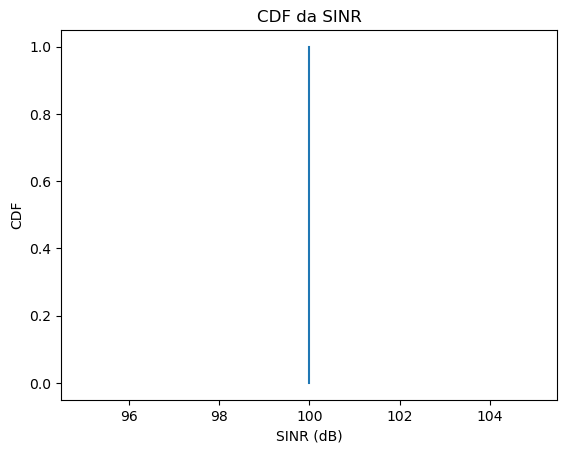

In [11]:
capacityCDF = eCDF(total_capacity)
SINR_CDF = eCDF(total_SINR)
SNR_CDF = eCDF(total_SNR)

plt.title('CDF da SINR')
plt.xlabel('SINR (dB)')
plt.ylabel('CDF')

plt.plot(capacityCDF[0], capacityCDF[1])
plt.show()